# Sources and Weights

In [1]:
#| default_exp sources
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *

%load_ext autoreload
%autoreload 2
! date

Sun Dec 18 13:31:40 PST 2022


## Weight tables
We use a full-sky catalog analysis model, currently pointlike, see [source_weights](https://github.com/tburnett/pointlike/blob/master/python/uw/like2/.py), to evaluate the predicted flux from a source of interest with respect to the
background, the combined fluxes from all other sources. 

We choose the following binning:

* energy:  4/decade from 100 MeV to 1 TeV (but only upto 10 GeV really used)
* event types: Front/Back  
* Angular position: HEALPix, nside from 64 to 512 depending on the PSF 

In the tables, the energy index and event type are packed into a 1-byte band index, and the HEALPix index 
is in NEST order.

The table output also includes the predicted flux for each band, and the spectral model used.

### Plots of weight vs. radius

These plots, of a strong source with little background, and a weak one, show the
value of the weight vs. the radius of the pixels in the table. These is a 
plot for each energy/event type band. The top row has energies 100 MeV to 1 GeV,
the bottom row 1 GeV to 10 GeV, Front, in green, and Back in orange.
<figure style="margin-left: 25px" title="Figure 1">   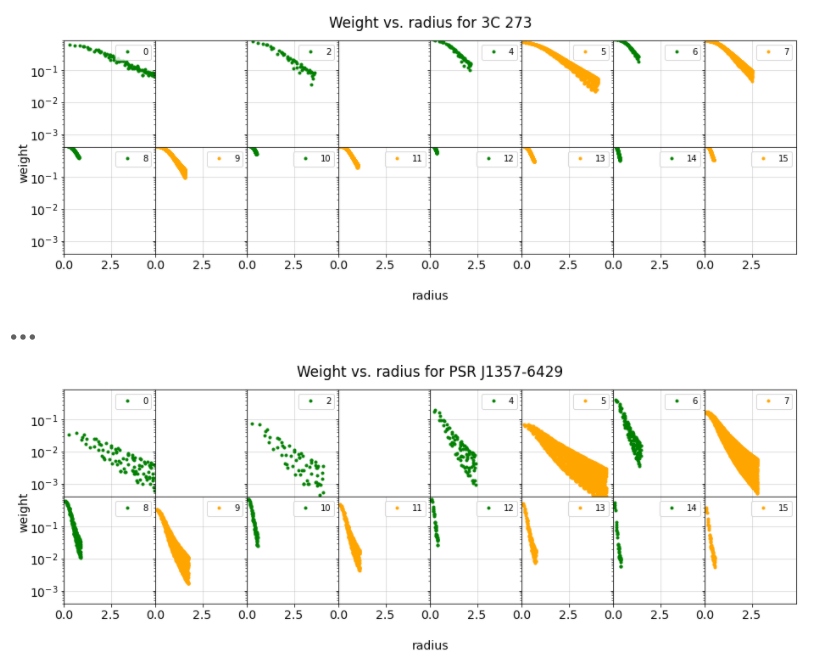 </figure>
Note the absense of Back for energies below 316 MeV. The pointlike model does not
compute these to avoid the larger PSF and Earth limb background. The maximum radius
per band is determined by the PSF. 


In [2]:
#| code-fold: true
@ipynb_doc
def weight_table_plots():
    """
    ### Plots of weight vs. radius
    
    These plots, of a strong source with little background, and a weak one, show the
    value of the weight vs. the radius of the pixels in the table. These is a 
    plot for each energy/event type band. The top row has energies 100 MeV to 1 GeV,
    the bottom row 1 GeV to 10 GeV, Front, in green, and Back in orange.
    {img}
    Note the absense of Back for energies below {Emid} MeV. The pointlike model does not
    compute these to avoid the larger PSF and Earth limb background. The maximum radius
    per band is determined by the PSF. 
    """
    Emid = round(10**2.5)
    img = image('weight_table_plots.png', caption=None)
    return locals()
weight_table_plots()

The local code used to do the unpacking is in the class `WeightMan`

This table is used with the data, as a simple lookup: A weight is assigned to each photon according to which energy, event type or HEALPix pixel it lands in.

In [3]:
#| include: false
from wtlike.config import *
import zipfile
from pathlib import Path
config = Config()
if config.valid:
    datapath=Path(config.datapath)
    wtfolder =datapath/'weight_files'

    nf = len(list(wtfolder.glob('*_weights.pkl')))

    with zipfile.ZipFile(datapath/'weight_files.zip') as wtzip:
        nzip = len(wtzip.filelist)

    print(f'Weight files: {nf} in {wtfolder.name}/ and {nzip} in weight_files.zip ')

Weight files: 14 in weight_files/ and 11472 in weight_files.zip 


### Accounting for variations from neighboring sources

Consider the case where sources $S_1$ and $S_2$ have overlapping pixels. For a given pixel and band, the corresponding weights are
$w_1$ and $w_2$, and we investigate the effect on $S_1$ from a fractional variation $\alpha_2 \ne 0$ of $S_2$, such that
its flux for that pixel, $s_2$, becomes $(1+\alpha )\ s_2$. With the background $b$, the flux of all
sources besides $S_1$ and $S_2$, we have for the $S_1$ weight,

$$ w_1 = \frac{s_1}{s_1+s_2+b}\ \ ,$$

and similarly for $S_2$.
Replacing $s_2$ with $(1+\alpha ) s_2$, we have for the modified weight $w_1'$ that we should use for  $S_1$,
$$w'_1 = \frac{w_1}{1+\alpha_2\ w_2}\ \ .   $$


In [4]:
#| export
import os, sys, pickle, healpy, zipfile
from pathlib import Path
import numpy as np
import pandas as pd

from scipy.integrate import quad
from astropy.coordinates import SkyCoord, Angle
from wtlike.config import *

In [5]:
#| export
def get_wtzip_index(config, update=False):

    wtzipfile = config.datapath/'weight_files.zip'
    if not  wtzipfile.is_file():
        print( f'Did not find the zip file {wtzipfile}', file=sys.stderr)
        return None

    with  zipfile.ZipFile(wtzipfile) as wtzip:
        if 'index.pkl' in wtzip.namelist() and not update:
            zi =  pickle.load(wtzip.open('index.pkl'))
#             if 'coord' in zi:
#                 print('Updating coord in index.pkl')

            zi['coord'] = SkyCoord(zi['glon'], zi['glat'], unit='deg', frame='galactic').fk5
            return zi

        if config.verbose>0:
            print(f'sources.get_wtzip_index: Extracting info from {wtzipfile}')
        name=[]; glat=[]; glon=[]
        for filename in wtzip.namelist():
            if filename=='index.pkl': continue
            with wtzip.open(filename) as file:
                wtd = pickle.load(file, encoding='latin1')
                l,b = wtd['source_lb']
                name.append(Path(filename).name.split('_weights.pkl')[0].replace('_',' ').replace('p','+') )
                glon.append(l)
                glat.append(b)
        zip_index = dict(name=np.array(name),
                         glon=np.array(glon), glat=np.array(glat),
                         #coord= SkyCoord(glon, glat, unit='deg', frame='galactic'),
                        )

        ### write to temp file, insert back into the zip
        ### SHould be a way to just stream
        pickle.dump(zip_index, open('/tmp/wtfile_index.pkl', 'wb'))
        with zipfile.ZipFile(wtzipfile, mode='a') as wtzip:
            wtzip.write('/tmp/wtfile_index.pkl', 'index.pkl')

        zip_index['coord'] = SkyCoord(zip_index['glon'], zip_index['glat'], unit='deg', frame='galactic').fk5
    return zip_index

In [6]:
#| export
class WeightMan(dict):
    """ Weight Management

    * Load weight tables
    * Assign weights to photons
    """

    def __init__(self, config, source):
        """
        """
        self.source = source
        nickname = source.nickname
        datapath =Path(config.datapath)

        filename = 'weight_files/'+nickname.replace(' ','_').replace('+','p')+'_weights.pkl'

        if (datapath/filename).exists():
            with open(datapath/filename, 'rb') as inp:
                wtd =  pickle.load(inp, encoding='latin1')

        elif (datapath/'weight_files.zip').exists():
            with  zipfile.ZipFile(datapath/'weight_files.zip') as wtzip:
                wtd =  pickle.load(wtzip.open(filename), encoding='latin1')

        else:
            raise Exception(f'No weight info found for {nickname}')

        self.update(wtd)
        self.__dict__.update(wtd)
        self.filename=filename
        self.config = config

        # check format--old has pixels, weights at tome
        srcfile = f'file "{self.filename}"' if self.source is None else f'file from source "{source.filename}"_weights.pkl'

        if hasattr(self, 'nside'):
            self.format=0
            if config.verbose>0:
                print(f'WeightMan: {srcfile} old format, nside={self.nside}')

            test_elements = 'energy_bins pixels weights nside model_name radius order roi_name'.split()
            assert np.all([x in wtd.keys() for x in test_elements]),f'Dict missing one of the keys {test_elements}'
            if config.verbose>0:
                print(f'Load weights from file {os.path.realpath(filename)}')
                pos = self['source_lb']
                print(f'\tFound: {self["source_name"]} at ({pos[0]:.2f}, {pos[1]:.2f})')
            # extract pixel ids and nside used
            self.wt_pix   = self['pixels']
            self.nside_wt = self['nside']

            # merge the weights into a table, with default nans
            # indexing is band id rows by weight pixel columns
            # append one empty column for photons not in a weight pixel
            # calculated weights are in a dict with band id keys
            self.wts = np.full((32, len(self.wt_pix)+1), np.nan, dtype=np.float32)
            weight_dict = self['weights']
            for k in weight_dict.keys():
                t = weight_dict[k]
                if len(t.shape)==2:
                    t = t.T[0] #???
                self.wts[k,:-1] = t

        else:
            self.format=1
            wtdict = self.wt_dict
            nsides = [v['nside'] for v in wtdict.values() ];

            if config.verbose>1:
                print(f'WeightMan: {srcfile} : {len(nsides)} bamds'\
                      f' with nsides {nsides[0]} to {nsides[-1]}')
            if self.source is not None:
                self.source.fit_info = self.fitinfo
                if config.verbose>2:
                    print(f'\tAdded fit info {self.fitinfo} to source')

    def _new_format(self, photons):

        wt_tables =self.wt_dict
        data_nside=1024
        photons.loc[:,'weight'] = np.nan

        if self.config.verbose>1:
            print(f'WeightMan: processing {len(photons):,} photons')

        def load_data( band_id):
            """ fetch pixels and weights for the band;
                adjust pixels to the band nside
                generate mask for pixels, weights
            """
            band = photons[photons.band==band_id] #.query('band== @band_id')
            wt_table = wt_tables[band_id]
            nside =  wt_table['nside']
            new_weights = wt_table['wts'].astype(np.float16)
            to_shift = int(2*np.log2(data_nside//nside))
            data_pixels = np.right_shift(band.nest_index, to_shift)
            wt_pixels=wt_table['pixels']
            good = np.isin( data_pixels, wt_pixels)
            if self.config.verbose>2:
                print(f'\t {band_id:2}: {len(band):8,} -> {sum(good ):8,}')
            return data_pixels, new_weights, good

        def set_weights(band_id):
            if band_id not in wt_tables.keys(): return

            data_pixels, new_weights, good = load_data(band_id)
            wt_pixels = wt_tables[band_id]['pixels']
            indicies = np.searchsorted( wt_pixels, data_pixels[good])
            new_wts = new_weights[indicies]
            # get subset of photons in this band, with new weights
            these_photons = photons[photons.band==band_id][good]
            these_photons.loc[:,'weight']=new_wts
            photons.loc[photons.band==band_id,'weight'] = (these_photons.weight).astype(np.float16)
    #         if self.config.verbose>1:
    #             print(f' -> {len(new_wts):8,}')

        for band_id in range(16):
            set_weights(band_id)

        return photons

    def add_weights(self, photons):
        """
        get the photon pixel ids, convert to NEST (if not already) and right shift them
        add column 'weight', remove `nest_index'
        remove rows with nan weight

        """
        assert photons is not None
        photons = self._new_format(photons)
        assert photons is not None

        # don't need these columns now (add flag to config to control??)
        if not getattr(self.config, 'keep_pixels', False):
            photons.drop(['nest_index'], axis=1, inplace=True)
            if self.config.verbose>2:
                print('Keeping pixels')
        noweight = np.isnan(photons.weight.values)
        if self.config.verbose>1:
            print(f'\tremove {sum(noweight):,} events without weight')

        ret = photons[np.logical_not(noweight)]
        assert ret is not None
        return ret

In [7]:
#| include: false
show_doc(WeightMan)
show_doc(WeightMan.add_weights)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/sources.py#L179){target="_blank" style="float:right; font-size:smaller"}

### WeightMan.add_weights

>      WeightMan.add_weights (photons)

get the photon pixel ids, convert to NEST (if not already) and right shift them
add column 'weight', remove `nest_index'
remove rows with nan weight

In [8]:
#| include: false

# def weight_radius_plots(photons):
#     """
#     """
#     import matplotlib.pyplot as plt

#     fig, axx = plt.subplots(2,8, figsize=(16,5), sharex=True, sharey=True)
#     plt.subplots_adjust(hspace=0.02, wspace=0)
#     for id,ax in enumerate(axx.flatten()):
#         subset = photons.query('band==@id & weight>0')
#         ax.semilogy(subset.radius, subset.weight, '.', label=f'{id}');
#         ax.legend(loc='upper right', fontsize=10)
#         ax.grid(alpha=0.5)
#     ax.set(ylim=(8e-4, 1.2), xlim=(0,4.9))
#     plt.suptitle('Weights vs. radius per band')

In [9]:
#| include: false
def findsource(*pars, gal=False):
    """
    Return a SkyCoord, looking up a name, or interpreting args

    Optional inputs: len(pars) is 1 for a source name or Jxxx, or 2 for coordinate pair
    - name -- look up the name, return None if not found
    - Jxxxx.x+yyyy -- intrepret  to get ra, dec, then convert
    - ra,dec -- assume frame=fk5
    - l,b, gal=True -- assume degrees, frame=galactic
    """

    import astropy.units as u
    if len(pars)==1:
        name = tname= pars[0]
        if name.startswith('4FGL '):
            # SkyCoord.from_name not updated for DR3. Use as Jname, ignoring that 'c'
            name = name[4:].replace('c','')
        if name.startswith('J') and (len(name)==10 or len(name)==12) and ('+' in name or '-' in name):
            # parse the name for (ra,dec)
            if name[5]!='.':
                tname = name[:5]+'.0'+name[5:]
            ra=(tname[1:3]+'h'+tname[3:7]+'m')
            dec = (tname[7:10]+'d'+tname[10:12]+'m')
            try:
                (ra,dec) = map(lambda a: float(Angle(a, unit=u.deg).to_string(decimal=True)),(ra,dec))
                skycoord = SkyCoord(ra, dec, unit='deg', frame='fk5')
            except ValueError:
                print(f'Attempt to parse {name} failed: expect "J1234.5+6789" or "J1234.5678"', file=sys.stderr)
                return None
        else:
            try:
                skycoord = SkyCoord.from_name(name)
            except Exception as e:
                # not found
                return None
    elif len(pars)==2:
        name = f'({pars[0]},{pars[1]})'
        #gal = kwargs.get('gal', False)
        skycoord=SkyCoord(*pars, unit='deg', frame='galactic' if gal else 'fk5')
    else:
        raise TypeError('require name or ra,dec or l,b,gal=True')
    return skycoord.galactic if gal else skycoord

In [10]:
show_doc(findsource, title_level=2)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/sources.py#L432){target="_blank" style="float:right; font-size:smaller"}

## findsource

>      findsource (*pars, gal=False)

Return a SkyCoord, looking up a name, or interpreting args

Optional inputs: len(pars) is 1 for a source name or Jxxx, or 2 for coordinate pair
- name -- look up the name, return None if not found
- Jxxxx.x+yyyy -- intrepret  to get ra, dec, then convert
- ra,dec -- assume frame=fk5
- l,b, gal=True -- assume degrees, frame=galactic

In [11]:
#| include: false
names = \
"""
J1740+1000
J1740.1-4444
BL Lac
CTA1
PSR J0007+7303
4FGL J0007.0+7303
Sagittarius A*
Sgr A*
Mkn 421
Vela
J1512.8-0906
junk
""".split('\n')
display_markdown(\
    """### Test findsource name lookup
    Uses astropy.coordinate.SkyCoord\nname{"l":>16}{"b":>10}
    """)
for name in names:
    if len(name)==0: continue
    r = findsource(name)
    if r is not None:
        l,b = r.galactic.l.value, r.galactic.b.value
    txt = '(not found)' if r is None else f'{l:07.3f}  {b:+07.3f}'
    print(f'{name:18} {txt}')
         

### Test findsource name lookup
    Uses astropy.coordinate.SkyCoord
name{"l":>16}{"b":>10}
    

J1740+1000         033.960  +20.364
J1740.1-4444       345.916  -07.313
BL Lac             092.590  -10.441
CTA1               119.580  +10.204
PSR J0007+7303     119.650  +10.600
4FGL J0007.0+7303  (not found)
Sagittarius A*     359.944  -00.046
Sgr A*             359.944  -00.046
Mkn 421            179.832  +65.031
Vela               263.939  -03.368
J1512.8-0906       351.279  +40.146
junk               (not found)


In [12]:
#| exporti
class WTSkyCoord(SkyCoord):
    def __repr__(self):
        ra,dec = self.fk5.ra.deg, self.fk5.dec.deg
        return f'({ra:.3f},{dec:.3f})'

In [13]:
#| export
import warnings
class FermiCatalog():

    def __init__(self,config=None, max_sep=0.1):
        from astropy.io import fits
        self.max_sep=max_sep
        if config is None:
            config = Config()
        fail=False
        # look for 4FGL catalog file, gll_psc_v28.fit currently
        if config.catalog_file is None:
                fail = True
        elif Path(config.catalog_file).is_file():
            self.catalog_file = Path(config.catalog_file).expanduser()
        else: fail=True

        if fail:
            warnings.warn('There is no link to 4FGL catalog file: set "catalog_file" in your config.yaml'
                  ' or specify if in the Config() call')
        else:
            # make this optional
            config.catalog_file = self.catalog_file
            with fits.open(self.catalog_file) as hdus:
                self.data = data = hdus[1].data

            cname = lambda n : [s.strip() for s in data[n]]
            cvar = lambda a: data[a].astype(float)
            ivar = lambda a: data[a].astype(int)
            name = list(map(lambda x: x.strip() , data['Source_Name']))

            self.skycoord = WTSkyCoord(data['RAJ2000'], data['DEJ2000'], unit='deg', frame='fk5')

            self.df = pd.DataFrame(dict(

                skycoord = self.skycoord,
                significance = cvar('Signif_Avg'),
                variability = cvar('Variability_Index'),
                assoc_prob  = cvar('ASSOC_PROB_BAY'), # for Bayesian, or _LR for likelihood ratio
                assoc1_name = cname('ASSOC1'),
                class1      = cname('CLASS1'),
                flags       = ivar('FLAGS'),
                # ....
            ))
            self.df.index = name
            self.df.index.name = 'name'

    def __repr__(self):
        return f'4FGL file {self.catalog_file.name} with {len(self)} entries'

    def field(self, colname):
        ## Todo: check type
        return self.data[colname]

    def __call__(self, skycoord):
        """select an entry by skydir return entry"""
        try:
            idx, sep2d, _= skycoord.match_to_catalog_sky(self.skycoord)
        except Exception as msg:
            print(f'Fail skycoord.match, {skycoord}: {msg}', file=sys.stderr)
            return
        csep = sep2d.deg[0]
        return self.df.iloc[idx] if csep < self.max_sep else None

    def __getitem__(self, name):   return self.df.loc[name]
    def __len__(self): return len(self.df)

In [14]:
#| include: false
config = Config()
if config.valid:
    cat = FermiCatalog(config)
    if cat:
        print(f'Lookup by name:\n {cat["4FGL J0001.2+4741"]}')
        print(f'Lookup by position:\n {cat(SkyCoord(9.017,15.999, unit="deg", frame="galactic"))}')

Lookup by name:
 skycoord        (0.313,47.686)
significance            4.6926
variability          25.313953
assoc_prob            0.996097
assoc1_name        B3 2358+474
class1                     bcu
flags                        0
Name: 4FGL J0001.2+4741, dtype: object
Lookup by position:
 skycoord        (257.156,-12.776)
significance             5.127852
variability              26.75452
assoc_prob                    0.0
assoc1_name                      
class1                           
flags                           8
Name: 4FGL J1708.6-1246, dtype: object


In [15]:
#| export
class SourceLookup():
    """ Use lists of the pointlike and catalog sources to check for correspondence of a name or position
    """

    max_sep = 0.1

    def __init__(self, config=None):
        from astropy.io import fits
        import pandas as pd
        self.config=config or Config()
        self.log = ''

        zip_index = get_wtzip_index(config)
        if zip_index is None:
            raise Exception('Expected zip file weight_files.zip')

        self.pt_dirs=zip_index['coord']
        self.pt_names = zip_index['name']

        catalog_file = Path(config.catalog_file).expanduser()
        self.catfile = catalog_file.name
        # make this optional
        with fits.open(catalog_file) as hdus:
            data = hdus[1].data
        self.cat_names = list(map(lambda x: x.strip() , data['Source_Name']))
        self.cat_dirs = SkyCoord(data['RAJ2000'], data['DEJ2000'], unit='deg', frame='fk5')

    def check_folder(self, *pars):
        if len(pars)>1: return None
        name = pars[0]
        filename = self.config.datapath/'weight_files'/(name.replace(' ','_').replace('+','p')+'_weights.pkl')
        if not filename.is_file():
            return None
        with open(filename, 'rb') as inp:
            wd = pickle.load(inp, encoding='latin1')

        #print(wd.keys(), wd['source_name'], wd['source_lb'])
        self.skycoord = SkyCoord( *wd['source_lb'], unit='deg', frame='galactic')
        self.check_4fgl()
        return name
    
    def findsource(self, *pars, gal=False):
        """
        Return a SkyCoord, looking up a name, or interpreting args

        Optional inputs: len(pars) is 1 for a source name or Jxxx, or 2 for coordinate pair
        - name -- look up the name, return None if not found
        - Jxxxx.x+yyyy -- intrepret  to get ra, dec, then convert
        - ra,dec -- assume frame=fk5
        - l,b, gal=True -- assume degrees, frame=galactic
        """

        import astropy.units as u
        if len(pars)==1:
            name = tname= pars[0]
            if name.startswith('4FGL '):
                # SkyCoord.from_name not updated for DR3. Use as Jname, ignoring that 'c'
                name = name[4:].replace('c','')
                self.log += f'\n\tRemove "4FGL, look up the J-name'
            if name.startswith('J') and (len(name)==10 or len(name)==12) and ('+' in name or '-' in name):
                # parse the name for (ra,dec)
                if name[5]!='.':
                    tname = name[:5]+'.0'+name[5:]
                ra=(tname[1:3]+'h'+tname[3:7]+'m')
                dec = (tname[7:10]+'d'+tname[10:12]+'m')
                try:
                    (ra,dec) = map(lambda a: float(Angle(a, unit=u.deg).to_string(decimal=True)),(ra,dec))
                    skycoord = SkyCoord(ra, dec, unit='deg', frame='fk5')
                except ValueError:
                    print(f'Attempt to parse {name} failed: expect "J1234.5+6789" or "J1234.5678"', file=sys.stderr)
                    return None
            else:
                try:
                    skycoord = SkyCoord.from_name(name)
                    self.log += f'\n\tlocated by astropy at ra,dec= {skycoord.ra.deg:.3f}, {skycoord.dec.deg:.3f}' 
                except Exception as e:
                    # not found
                    return None
        elif len(pars)==2:
            name = f'({pars[0]},{pars[1]})'
            #gal = kwargs.get('gal', False)
            skycoord=SkyCoord(*pars, unit='deg', frame='galactic' if gal else 'fk5')
        else:
            raise TypeError('require name or ra,dec or l,b,gal=True')
        return skycoord.galactic if gal else skycoord

    def __call__(self, *pars, **kwargs):
        """
        Search the catalog lists. Options are:

        * name of a pointlike source
        * name of a source found by astropy, or a coordinate, which is close to a source in the pointlike list
        * a coordinate pair (ra,dec), or (l,b, gal=True)

        Returns the pointlike name.
        """
        self.psep=self.csep=99 # flag not found
        self.cat_name = None

        # first, is the name in the weidht_files folder?
        name = self.check_folder(*pars)
        if name is not None:  
            self.log += f'\nFound in {self.catfile}' 
            return name

        # then check pointlike list
        if self.pt_names is not None and len(pars)==1 and pars[0] in self.pt_names:
            idx = list(self.pt_names).index(pars[0])
            skycoord = self.pt_dirs[idx]
            self.log += '\n\tFound in pointlike weight tables' 
        else:
            # get coord either by known catalog name, or explict coordinate pair
            try:
                skycoord = self.findsource(*pars, **kwargs)
            except TypeError as err:
                print(err, file=sys.stderr)
                return None
            except ValueError as err:
                print(err, file=sys.stderr)
                return None
            if skycoord is None:
                self.log += f'\n\t not found by astropy, and not in the pointlike list'
                # print(error, file=sys.stderr)
                return None


        self.psep=0
        # print(f'looking up: {skycoord} ', end='')
        # print(f'in {self.pt_dirs}')
        try:
            idx, sep2d, _= skycoord.match_to_catalog_sky(self.pt_dirs)
        except Exception as msg:
            print(f'\nFail SkyCoord catalog lookup: {self.pt_dirs}, {msg}', file=sys.stderr)
            return None

        self.psep = sep = sep2d.deg[0]
        pt_name =  self.pt_names[idx]
        if sep > self.max_sep:
            self.log += f'\n\t is {sep:.2f} deg > {self.max_sep} from pointlike source {pt_name}'
            return None
        self.skycoord=skycoord
        self.check_4fgl()
        return pt_name

    def check_4fgl(self):
        # check for 4FGL correspondence, set self.cat_name, self.csep
        if len(self.cat_dirs)==0:
            self.cat_name=None
            return

        idx, sep2d, _= self.skycoord.match_to_catalog_sky(self.cat_dirs)
        self.csep = sep2d.deg[0]
        self.cat_name = self.cat_names[idx] if self.csep < self.max_sep else None

### for consistency
def findsource(name, gal=True):
    return SourceLookup(Config()).findsource(name,gal=gal)

# findsource('Geminga')

In [16]:
show_doc(SourceLookup)
show_doc(SourceLookup.__call__)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/sources.py#L363){target="_blank" style="float:right; font-size:smaller"}

### SourceLookup.__call__

>      SourceLookup.__call__ (*pars, **kwargs)

Search the catalog lists. Options are:

* name of a pointlike source
* name of a source found by astropy, or a coordinate, which is close to a source in the pointlike list
* a coordinate pair (ra,dec), or (l,b, gal=True)

Returns the pointlike name.

In [17]:
#| include: false 
config=Config() #catalog_file=None)
if config.valid:
    sl = SourceLookup(config);

    tests =\
    """
    # cause problems?
    J1740+1000
    03bF-0173 
    4FGL J1510.1-5750
    4FGL J1749.5-2747
    J1749.5-2747 
    J1818.5-2036
    
    # should all be the same
    Mkn 421
    P88Y2756
    4FGL J1104.4+3812

    # the GC source
    Sgr A*
    
    Geminga

    # should fail, name not exact match
    4FGL J1512.8-0905

    # OK, since lookup by position
    J1512.8-0905

    # Name ok, but not near a gamma-ray source
    IC 1623

    # Pointlike source not in 4FGL, and its BL Lac association
    211F-1019
    87GB 234805.5+360514
    
    # pulsars in 4FGL, but use its name
    PSR B1259-63
    PSR J0205+6449
    """.split('\n')
    for line in tests:
        t = line.strip()
        if len(t)==0 or t[0]=='#': 
            print(t)
        else: 
            print(f' {t:20s}--> {sl(t)} ({sl.cat_name})')
    print(f' {"0,0":20s}--> {sl(0,0)}')
    print(f' {"0,0,gal=True":20s}--> {sl(0,0, gal=True)}  ({sl.cat_name})')


# cause problems?
 J1740+1000          --> None (None)
 03bF-0173           --> 03bF-0173 (None)
 4FGL J1510.1-5750   --> None (None)
 4FGL J1749.5-2747   --> None (None)
 J1749.5-2747        --> 211P-0480 (4FGL J1749.5-2747)
 J1818.5-2036        --> None (None)

# should all be the same
 Mkn 421             --> P88Y2756 (4FGL J1104.4+3812)
 P88Y2756            --> P88Y2756 (4FGL J1104.4+3812)
 4FGL J1104.4+3812   --> None (None)

# the GC source
 Sgr A*              --> P88Y4744 (4FGL J1745.6-2859)

 Geminga             --> Geminga (4FGL J0633.9+1746)

# should fail, name not exact match
 4FGL J1512.8-0905   --> None (None)

# OK, since lookup by position
 J1512.8-0905        --> P88Y3867 (4FGL J1512.8-0906)

# Name ok, but not near a gamma-ray source
 IC 1623             --> None (None)

# Pointlike source not in 4FGL, and its BL Lac association
 211F-1019           --> 211F-1019 (None)
 87GB 234805.5+360514--> 211F-1019 (None)

# pulsars in 4FGL, but use its name
 PSR B1259-63     

In [18]:
#| export

class PointSource():
    """Manage the position and name of a point source
    """
    def __init__(self, *pars, **kwargs):
        """

        """
        config = self.config = kwargs.pop('config', Config())
        lookup = SourceLookup(config)
        gal = kwargs.get('gal', False)
        self.nickname = pt_name = lookup(*pars, ** kwargs )
        if pt_name is None:
            raise Exception(f'Source lookup using "{pars}" failed.')
        self.skycoord = lookup.skycoord
        #print(pars)
        if len(pars)==1:
            name = pars[0]
            if name==pt_name and lookup.cat_name is not None:
                name = lookup.cat_name
        else:
            gal = kwargs.get('gal', False)
            name=f'{"fk5" if not gal else "gal"} ({pars[0]},{pars[1]}) '
        self.name = name
        gal = self.skycoord.galactic
        self.l, self.b = gal.l.deg, gal.b.deg
        self.cat_name = lookup.cat_name
        # override 4FGL if identifiec pulasr
        if self.nickname.startswith('PSR ') and self.cat_name is not None and self.cat_name.startswith('4FGL '):
            self.name = self.nickname
        # use cat name if used J-name to find it
        elif self.name.startswith('J') and self.cat_name is not None and self.cat_name.startswith('4FGL'):
            self.name = self.cat_name

        try:
            self.wtman = WeightMan(self.config, self)
            # add wtman attribute references
            self.__dict__.update(self.wtman.__dict__)
        except Exception as e:
            print(f'Unexpected Weigthman failure: {e}', file=sys.stderr)
            raise


    def __str__(self):
        return f'Source "{self.name}" at: (l,b)=({self.l:.3f},{self.b:.3f}), nickname {self.nickname}'
    def __repr__(self): return str(self)

    @property
    def ra(self):
        sk = self.skycoord.transform_to('fk5')
        return sk.ra.value
    @property
    def dec(self):
        sk = self.skycoord.transform_to('fk5')
        return sk.dec.value

    @property
    def filename(self):
        """Modified name for file system"""
        return self.name.replace(' ', '_').replace('+','p') if getattr(self,'nickname',None) is None else self.nickname

    @property
    def jname(self):
        """Return name in the format Jhhmm.m+ddmm
        note that last digits are truncated, not rounded
        http://cds.u-strasbg.fr/vizier/Dic/iau-spec.htx#S3.2.1
        """
        import numpy as np
        mm = np.mod(self.ra*4,1440) # RA in minutes 
        ss = np.mod(mm*60,60) #seconds
        HH,MM = int(mm/60), int(mm%60)
        m = int(ss/6) # prescription for .1 min digit
        sign= '+' if self.dec>=0 else '-'
        dem = int(abs(self.dec)*60) #abs( DEC) in minutes, truncated
        return 'J' +   '{:02d}{:02d}.{:1d}'.format(HH,MM,m)\
                + sign+'{:02d}{:02.0f}'.format(int(dem/60),dem%60)
    
    @classmethod
    def fk5(cls, name, position):
        """position: (ra,dec) tuple """
        ra,dec = position
        sk = SkyCoord(ra, dec, unit='deg',  frame='fk5').transform_to('galactic')
        return cls(name, (sk.l.value, sk.b.value))

    @property
    def spectral_model(self):
        if not hasattr(self, 'fit_info'): return None
        modelname = self.fit_info['modelname']
        pars = self.fit_info['pars']
        if modelname=='LogParabola':
            return self.LogParabola(pars)
        elif modelname=='PLSuperExpCutoff':
            return self.PLSuperExpCutoff(pars)
        else:
            raise Exception(f'PointSource: Unrecognized spectral model name {fi["modelname"]}')

    def __call__(self, energy):
        """if wtman set, return photon flux at energy"""
        return self.spectral_model(energy) if self.spectral_model else None

    def sed_plot(self, ax=None, figsize=(5,4), **kwargs):
        """Make an SED for the source

        - kwargs -- for the Axes object (xlim, ylim, etc.)
        """
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=figsize) if ax is None else (ax.figure, ax)
        x =np.logspace(2,5,61)
        y = self(x)
        ax.loglog(x/1e3, y*x**2 * 1e6, '-')
        ax.grid(alpha=0.5)
        kw = dict(xlabel='Energy (GeV)',
                  ylabel=r'$\mathrm{Energy\ Flux\ (eV\ cm^{-2}\ s^{-1})}$',
                  title=f'{self.name}',
                  xlim=(x.min()/1e3,x.max()/1e3),
                 )
        kw.update(kwargs)
        ax.set(**kw)

    class FluxModel():
        emin, emax = 1e2, 1e5
        def __init__(self, pars, e0=1000):
            self.pars=pars
            self.e0=e0

        def photon_flux(self):
            return quad(self, self.emin, self.emax)[0]

        def energy_flux(self):
            func = lambda e: self(e) * e**2
            return quad(func, self.emin, self.emax)[0]

    class LogParabola(FluxModel):

        def __call__(self, e):
            n0,alpha,beta,e_break=self.pars
            x = np.log(e_break/e)
            y = (alpha - beta*x)*x
            return n0*np.exp(y)

    class PLSuperExpCutoff(FluxModel):

        def __call__(self,e):
            #print('WARNING: check e0!')
            n0,gamma,cutoff,b=self.pars
            return n0*(self.e0/e)**gamma*np.exp(-(e/cutoff)**b)

In [19]:
show_doc(PointSource)
show_doc(PointSource.fk5)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/sources.py#L514){target="_blank" style="float:right; font-size:smaller"}

### PointSource.fk5

>      PointSource.fk5 (name, position)

position: (ra,dec) tuple

In [20]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Sun Dec 18 13:31:47 PST 2022
